In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mping
from moviepy.editor import VideoFileClip
from ipywidgets import interact,interactive,fixed
from IPython.display import HTML

%matplotlib inline

print('...')


...


# First, calibrate the camera with chessboard

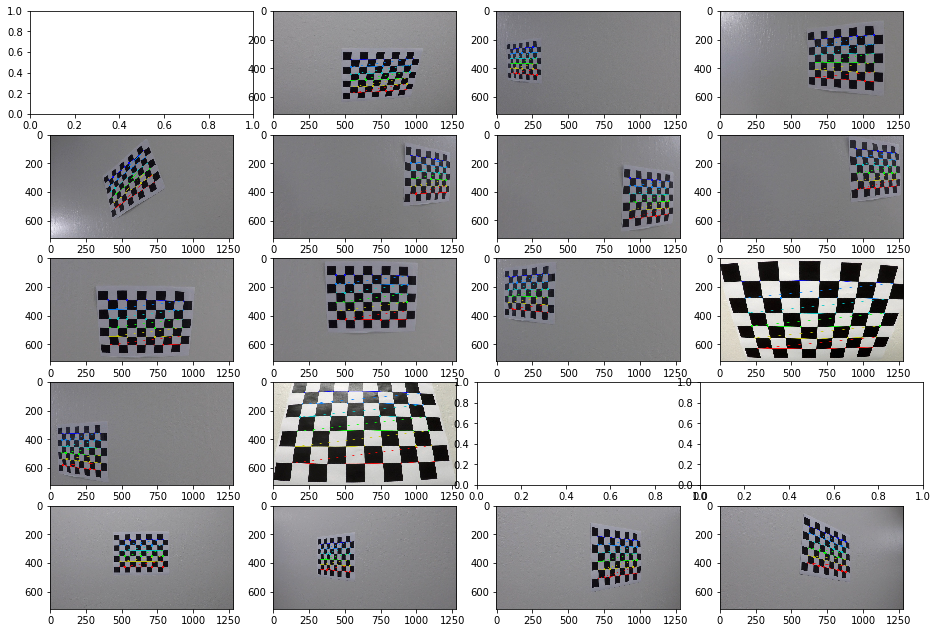

In [3]:
# find corners of chessborad
# prepare the object points
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# define blank arrays to store the object and image points
objpoints = [] # 3d points in world space
imgpoints = [] # 2d points in image space
    
# make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# step through the list and search for chessboard corners
for i,fname in enumerate(images):
    img = mping.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
    ret,corners = cv2.findChessboardCorners(gray,(9,6),None) # find the chessboard corners
        
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # display the corners
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret)
        #cv2.imshow('input image',img)
        #cv2.waitKey(500)
        
        axs[i].imshow(img)


### there are some blank images due to the expected corners of chessboard were not found

...


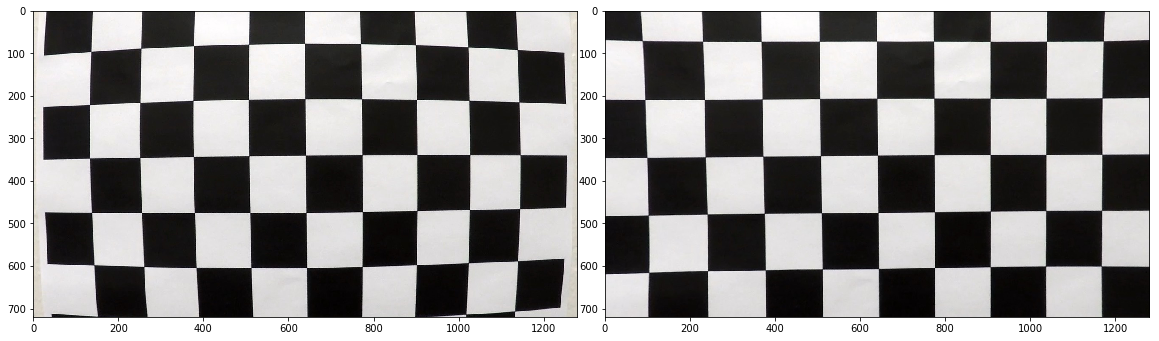

In [4]:
# camera calibration and undistortion with calibration images

img = mping.imread('./camera_cal/calibration1.jpg')

img_size = (img.shape[1],img.shape[0])
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

undist = cv2.undistort(img,mtx,dist,None,mtx)

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax2.imshow(undist)

'''
gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    
ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
if ret == True:
    cv2.drawChessboardCorners(undist,(nx,ny),corners,ret)
        
    offset = 100
        
    img_size = (gray.shape[1],gray.shape[0])
        
    src = np.flaot32([corners[0],corners[nx - 1],corners[-1],corners[-nx]])
        
    dst = np.float32([[offset,offset],[img_size[0] - offset,offset],[img_size[0] - offset,img_size[1] - offset],[offset,img_size[1] - offset]])
        
    M = cv2.getPerspectiveTransform(src,dst)
        
    warped = cv2.warpPerspective(undist,M,img_size)
'''    
print('...')

In [5]:
# save the calibration file for later use

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle,open('calibration_file.p','wb'))

print('calibration file saved')

calibration file saved


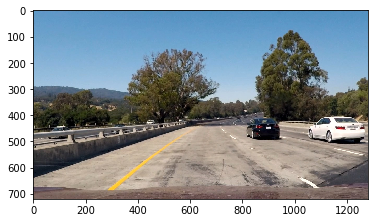

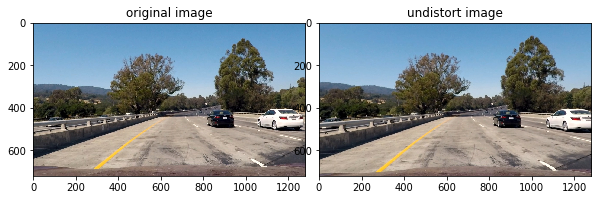

In [6]:
# read test images and undistort images with the calibration file obtained above

test_image = mping.imread('./test_images/test1.jpg')

plt.imshow(test_image)

def undistort(img):

    undist = cv2.undistort(img,mtx,dist,None,mtx)
    
    return undist

# visualization of the original and undistort images
undist = undistort(test_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_image)
ax1.set_title('original image')
ax2.imshow(undist)
ax2.set_title('undistort image')

# Perspective Transform

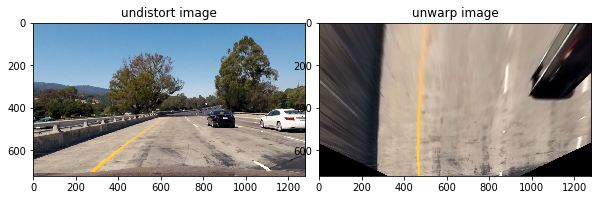

In [7]:
# perspective transform

def unwarp(img,src,dst):
    
    height,weight = img.shape[:2]
    # the cv2.getPerspectiveTransform function was used to obtain the transform matrix and inverse matrix
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    # use warpPerspective function to obtain the top-down view
    unwarp = cv2.warpPerspective(img,M,(weight,height),flags = cv2.INTER_LINEAR)
    
    return unwarp,M,M_inv

height,weight = img.shape[:2]
src = np.float32([(575,464),(707,464),(258,682),(1049,682)])
dst = np.float32([(450,0),(weight - 450,0),(450,height),(weight - 450,height)])

unwarp,M,M_inv= unwarp(undist,src,dst)

# visualise the unwarp view
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist)
ax1.set_title('undistort image')
ax2.imshow(unwarp)
ax2.set_title('unwarp image')


# Visualize the colorspace channels with different method(RGB,HSV)

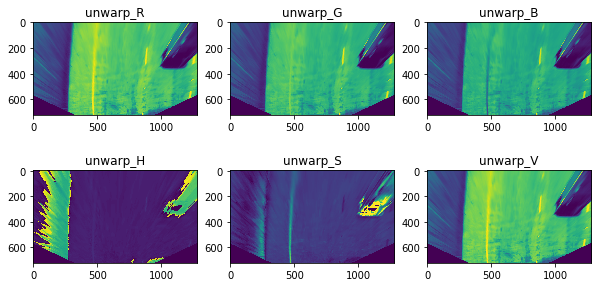

In [8]:
# visualization of multiple colorspace channels

unwarp_R = unwarp[:,:,0]
unwarp_G = unwarp[:,:,1]
unwarp_B = unwarp[:,:,2]

unwarp_HSV = cv2.cvtColor(unwarp,cv2.COLOR_RGB2HSV)
unwarp_H = unwarp_HSV[:,:,0]
unwarp_S = unwarp_HSV[:,:,1]
unwarp_V = unwarp_HSV[:,:,2]

fig,axs = plt.subplots(2,3,figsize = (10,5))
f.subplots_adjust(hspace = .2, wspace=.05)
axs = axs.ravel()

axs[0].imshow(unwarp_R)
axs[0].set_title('unwarp_R')
axs[1].imshow(unwarp_G)
axs[1].set_title('unwarp_G')
axs[2].imshow(unwarp_B)
axs[2].set_title('unwarp_B')

axs[3].imshow(unwarp_H)
axs[3].set_title('unwarp_H')
axs[4].imshow(unwarp_S)
axs[4].set_title('unwarp_S')
axs[5].imshow(unwarp_V)
axs[5].set_title('unwarp_V')

# Threshold define

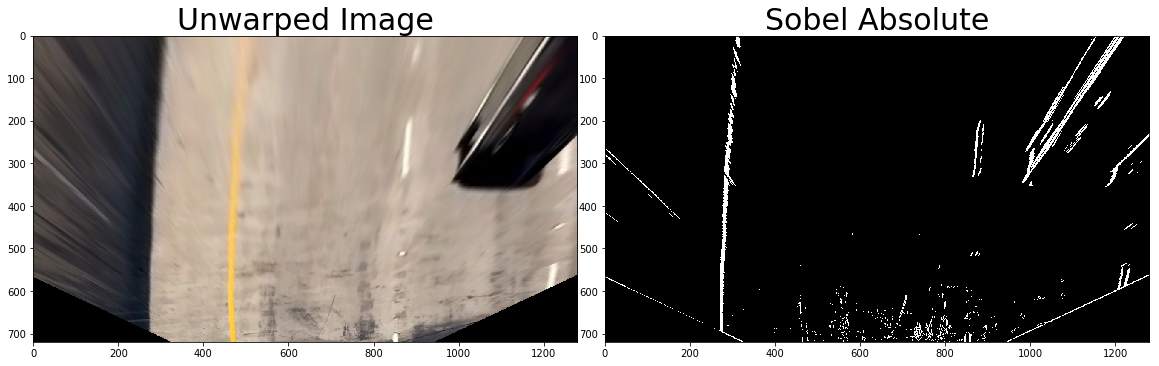

In [9]:
# Threshold

def abs_sobel_thresh(img,orient = 'x',thresh_min = 25,thresh_max = 255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1))
        
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output[(scaled_sobel >= thresh_min)&(scaled_sobel<=thresh_max)] = 1
    
    return binary_output

sobelAbs = abs_sobel_thresh(unwarp,orient = 'x',thresh_min = 25,thresh_max = 255)

# visualize sobel absolute threshold on test image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(sobelAbs, cmap='gray')
ax2.set_title('Sobel Absolute', fontsize=30)

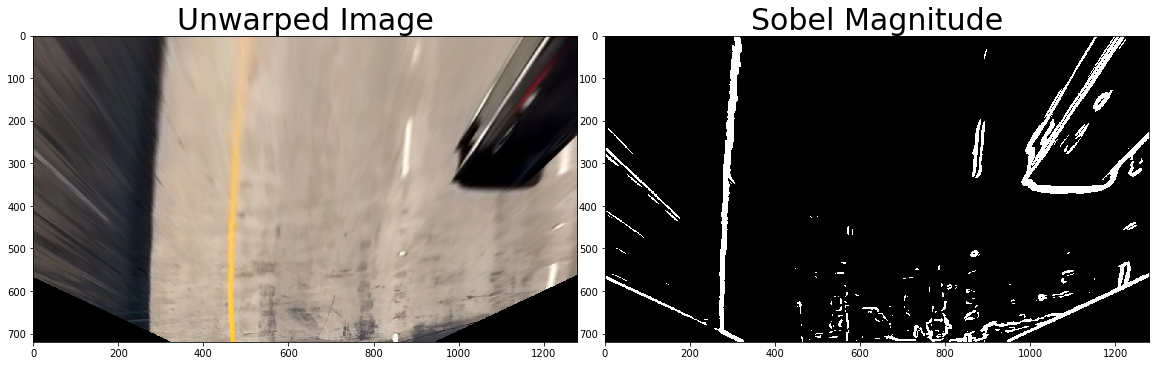

In [10]:
# Define a function that applies Sobel x and y,then computes the magnitude of the gradient and applies a threshold

def mag_thresh(img,sobel_kernel = 25,mag_thresh = (25,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

sobelMag = mag_thresh(unwarp,sobel_kernel = 25,mag_thresh = (25,255))

# Visualize sobel magnitude threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(sobelMag, cmap='gray')
ax2.set_title('Sobel Magnitude', fontsize=30)

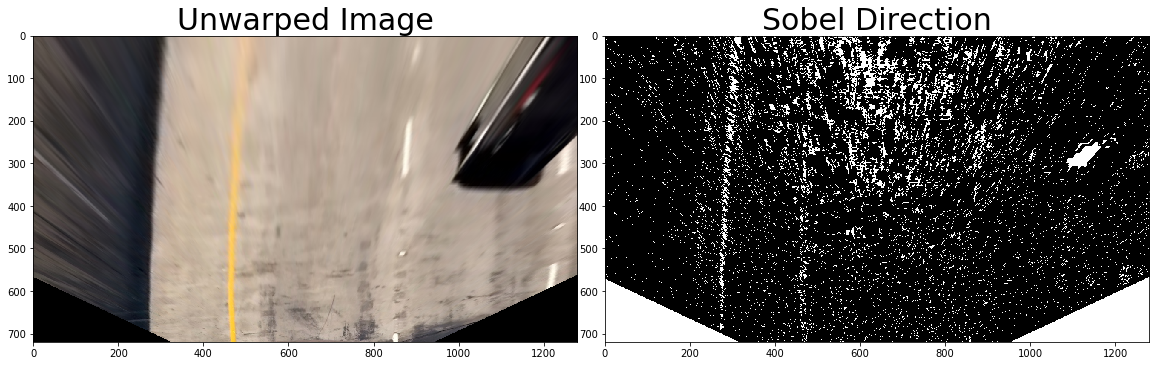

In [11]:
# Define a function that applies Sobel x and y,then computes the direction of the gradient and applies a threshold.

def dir_threshold(img,sobel_kernel = 7, thresh = (0,np.pi/2)):
    
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

sobelDir = dir_threshold(unwarp,sobel_kernel = 7, thresh = (0,0.09))

# Visualize sobel direction threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(sobelDir, cmap='gray')
ax2.set_title('Sobel Direction', fontsize=30)


## combine the different thresholds (manitude and direction)

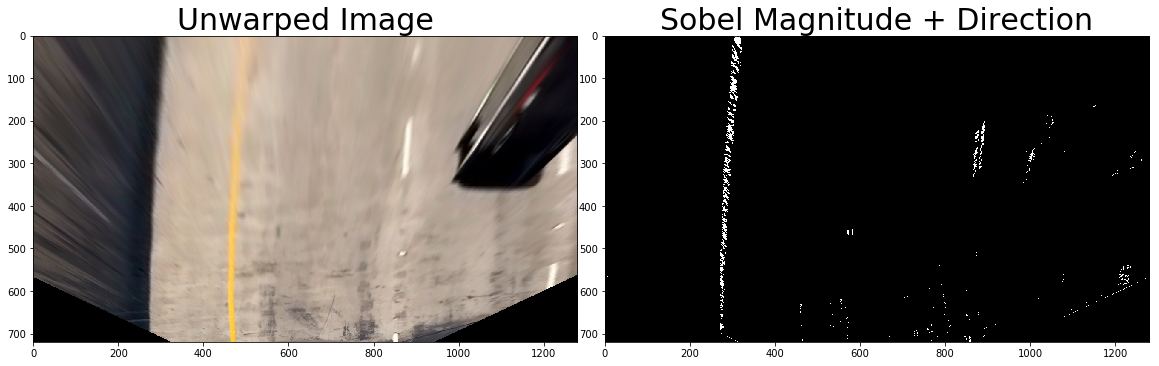

In [12]:
# threshold combination
    
combined_binary = np.zeros_like(sobelMag)
combined_binary[((sobelMag == 1)&(sobelDir == 1))] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Sobel Magnitude + Direction', fontsize=30)

### the combination of magnitude and direction was not good enough for the recognization, but it was better than the combination of absolute and other two.

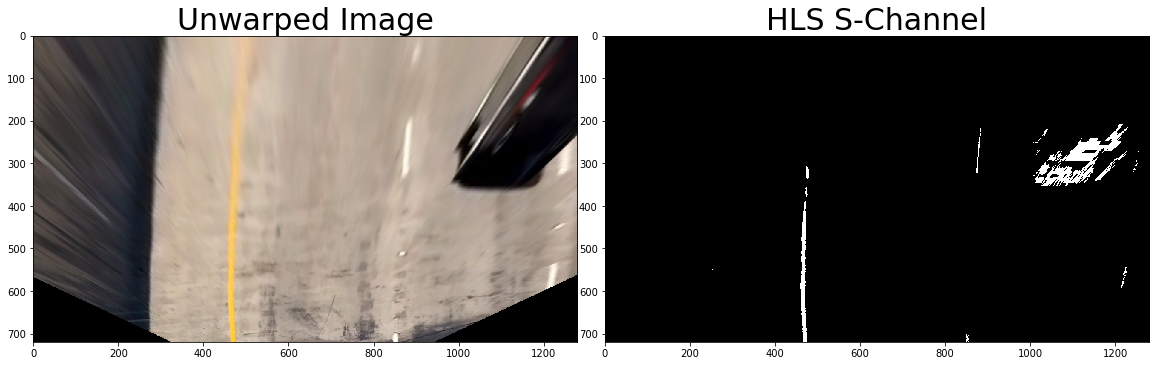

In [15]:
# HLS Channel Threshold
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_sthresh(img,thresh = (220,255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    hls_s = hls[:,:,2]*(255/np.max(hls[:,:,2]))
    
    binary_output = np.zeros_like(hls_s)
    binary_output[(hls_s > thresh[0])&(hls_s <= thresh[1])] = 1
    
    return binary_output

sobel_Lthresh = hls_sthresh(unwarp,thresh = (220,255))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(sobel_Lthresh, cmap='gray')
ax2.set_title('HLS S-Channel', fontsize=30)
    

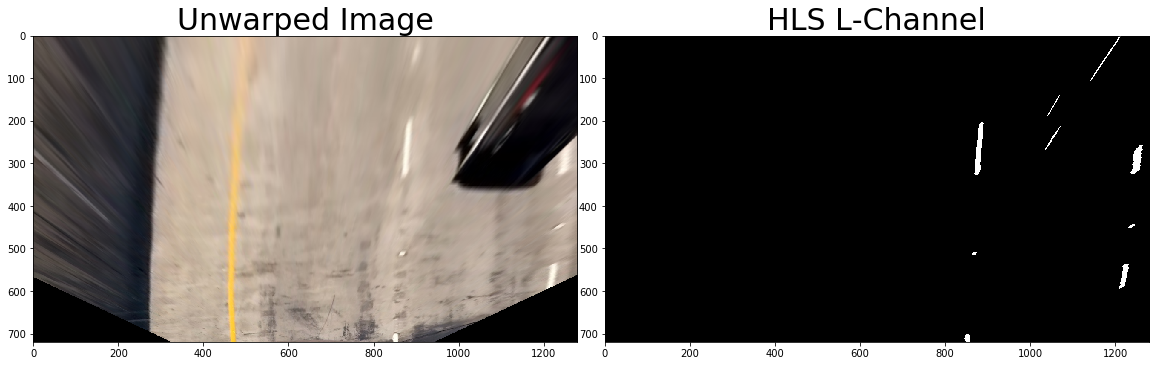

In [16]:
# HLS Channel Threshold
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img,thresh = (220,255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the L channel
    hls_l = hls[:,:,1]*(255/np.max(hls[:,:,1]))
    
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0])&(hls_l <= thresh[1])] = 1
    
    return binary_output

sobel_Lthresh = hls_lthresh(unwarp,thresh = (220,255))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(sobel_Lthresh, cmap='gray')
ax2.set_title('HLS L-Channel', fontsize=30)
    

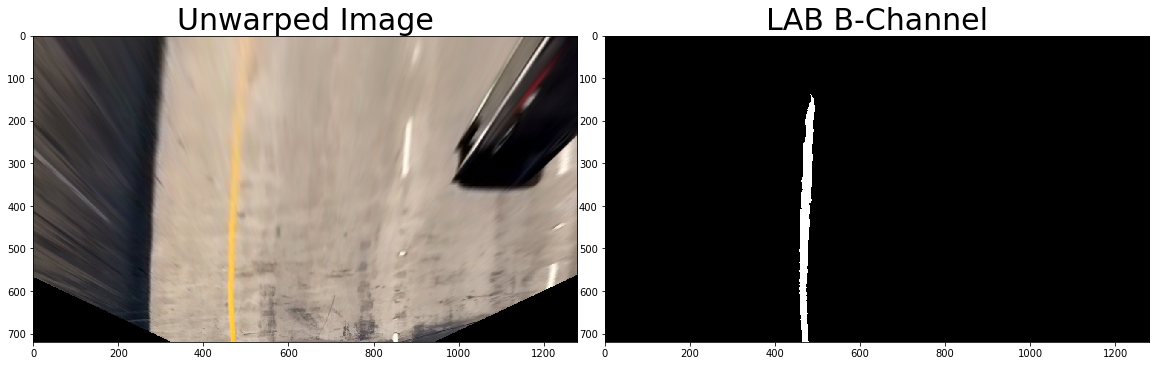

In [17]:
# Lab Colorspace
# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture yellows)

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

sobel_LBThresh = lab_bthresh(unwarp, thresh=(190,255))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(unwarp)
ax1.set_title('Unwarped Image', fontsize=30)
ax2.imshow(sobel_LBThresh, cmap='gray')
ax2.set_title('LAB B-Channel', fontsize=30)

# Image Processing Pipeline

In [18]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified

def pipeline(img):
    
    # undistort image
    undist = undistort(img)
    
    # perspective transform the image
    height,weight = undist.shape[:2]
    src = np.float32([(575,464),(707,464),(258,682),(1049,682)])
    dst = np.float32([(450,0),(weight - 450,0),(450,height),(weight - 450,height)])
    
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    unwarp = cv2.warpPerspective(img,M,(weight,height),flags = cv2.INTER_LINEAR)
    
    #sobelAbs = abs_sobel_thresh(unwarp,orient = 'x',thresh_min = 25,thresh_max = 255)
    
    #sobelMag = mag_thresh(unwarp,sobel_kernel = 25,mag_thresh = (25,255))
    
    #sobelDir = dir_threshold(unwarp,sobel_kernel = 7, thresh = (0,0.09))
    
    # HLS L-channel Threshold
    sobel_Lthresh = hls_lthresh(unwarp,thresh = (220,255))
    
    # Lab B-channel Threshold
    sobel_LBThresh = lab_bthresh(unwarp, thresh=(190,255))
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(sobel_Lthresh)
    #combined[(sobelAbs == 1)&(sobelMag == 1)&(sobelDir == 1)] = 1
    combined[(sobel_Lthresh == 1) | (sobel_LBThresh == 1)] = 1
    
    return combined, M_inv




# Load all test images and run the pipeline to obtain the perspective transform and thresholds

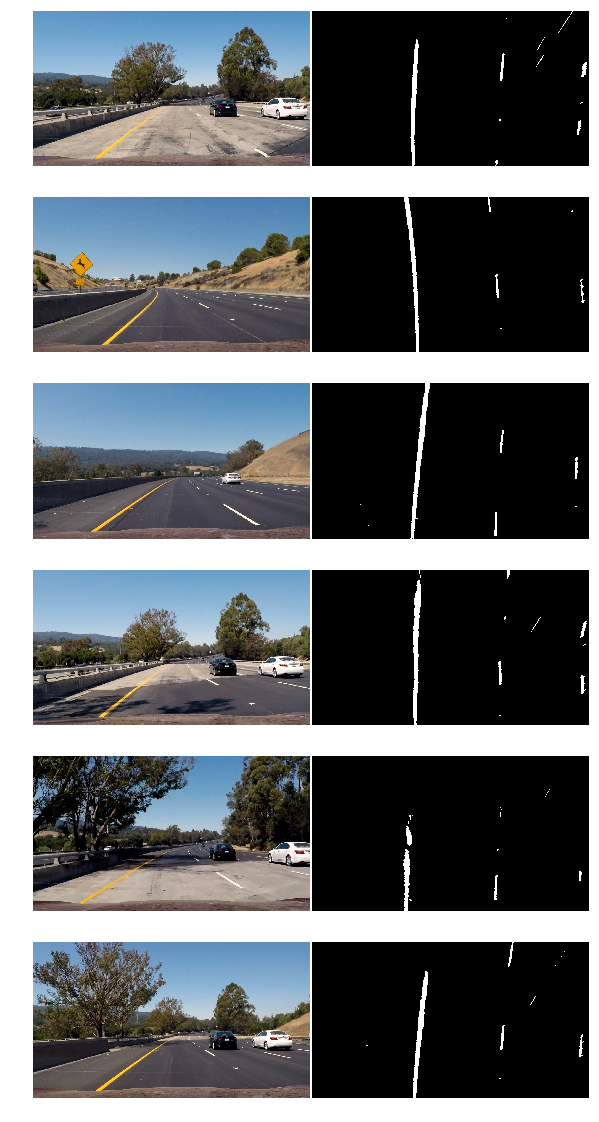

In [19]:
images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in images:
    img = mping.imread(image)
    img_bin,M_inv = pipeline(img)
    
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

# Lane line locating and line polyfit

In [20]:
# polyfit
# Define method to fit polynomial to binary image with lines extracted, using sliding window

def lane_locating(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis = 0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((binary_warped,binary_warped,binary_warped))*255)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarterpoint = np.int(midpoint//2)
    
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarterpoint:midpoint]) + quarterpoint
    rightx_base = np.argmax(histogram[midpoint:quarterpoint + midpoint]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Rectangle data for visualization
    rectangle_data = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        rectangle_data.append((win_y_low,win_y_high,win_xleft_low,win_xleft_high,win_xright_low,win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&(nonzerox >= win_xleft_low)&(nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&(nonzerox >= win_xright_low)&(nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit,right_fit = (None,None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty,leftx,2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty,rightx,2)
    
    visualization_data = (rectangle_data,histogram)

    return out_img,left_fit,right_fit,left_lane_inds,right_lane_inds,visualization_data



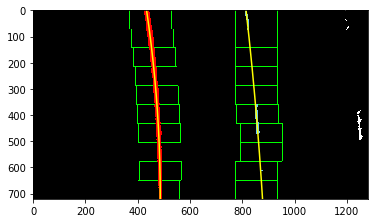

(0, 1280)

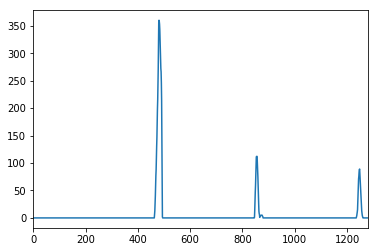

In [21]:
test_image = mping.imread('./test_images/test2.jpg')
test_img_bin,M_inv = pipeline(test_image)

out_img,left_fit,right_fit,left_lane_inds,right_lane_inds,visualization_data = lane_locating(test_img_bin)

rectangles = visualization_data[0]
histogram = visualization_data[1]


h = test_image.shape[0]
left_fitx_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fitx_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

for rect in rectangles:
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0),2)
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0),2)

# Generate x and y values for plotting
ploty = np.linspace(0,test_img_bin.shape[0] - 1,test_img_bin.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



nonzero = test_img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
        
out_img[nonzeroy[left_lane_inds],nonzerox[left_lane_inds]] = [255,0,0]
out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [100,200,255]
        
plt.imshow(out_img)
plt.plot(left_fitx,ploty,color = 'yellow')
plt.plot(right_fitx,ploty,color = 'yellow')
plt.xlim(0,1280)
plt.ylim(720,0)
plt.show()
# Print histogram from sliding window polyfit for example image
plt.plot(histogram)
plt.xlim(0,1280)

# Polyfit using fit from previous frame

(720, 0)

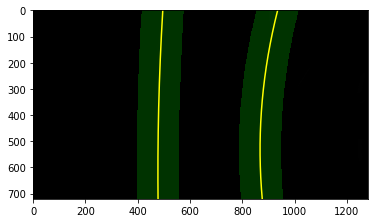

In [22]:
# lane detection after the first image

# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def window_search(left_fit, right_fit, binary_warped):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 80
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))&(nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))&(nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    left_fit_new,right_fit_new = (None,None)
    
    if len(leftx)!= 0:
        left_fit_new = np.polyfit(lefty,leftx,2)
    if len(rightx)!= 0:
        right_fit_new = np.polyfit(righty,rightx,2)
    
    return left_fit_new,right_fit_new,left_lane_inds,right_lane_inds

new_test_image = mping.imread('./test_images/test4.jpg')
new_test_img_bin,M_inv = pipeline(new_test_image)
margin = 80

left_fit_new,right_fit_new,left_lane_inds_new,right_lane_inds_new = window_search(left_fit, right_fit, new_test_img_bin)

ploty = np.linspace(0,new_test_img_bin.shape[0] - 1,new_test_img_bin.shape[0])

left_fitx_new = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx_new = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]

out_img = np.dstack((new_test_img_bin,new_test_img_bin,new_test_img_bin))*255
window_img = np.zeros_like(out_img)

nonzero = new_test_img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
        
out_img[nonzeroy[left_lane_inds_new],nonzerox[left_lane_inds_new]] = [255,0,0]
out_img[nonzeroy[right_lane_inds_new],nonzerox[right_lane_inds_new]] = [0,0,255]
        
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx_new - margin,ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx_new + margin,ploty])))])
left_line_pts = np.hstack((left_line_window1,left_line_window2))
        
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx_new - margin,ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx_new + margin,ploty])))])
right_line_pts = np.hstack((right_line_window1,right_line_window2))
        
cv2.fillPoly(window_img,np.int_([left_line_pts]),(0,255,0))
cv2.fillPoly(window_img,np.int_([right_line_pts]),(0,255,0))
result = cv2.addWeighted(out_img,1,window_img,0.3,0)
plt.imshow(result)
plt.plot(left_fitx_new,ploty,color = 'yellow')
plt.plot(right_fitx_new,ploty,color = 'yellow')
plt.xlim(0,1280)
plt.ylim(720,0)


# Measurements of radius of curvature and distance from lane center

In [23]:
# radius of curvature and distance from lane center based on binary image, polynomial fit, and L and R lane pixel indices

def curvature(img_bin,left_fit,right_fit,left_lane_inds,right_lane_inds):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720
    xm_per_pix = 3.7/378
    left_curverad,right_curverad,center_dist = (0,0,0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    height = img_bin.shape[0]
    ploty = np.linspace(0,h - 1,h)
    y_eval = np.max(ploty)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx)!= 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
        right_fit_cr = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = img_bin.shape[1]/2
        left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (right_fit_x_int + left_fit_x_int)/2
        center_dist = (car_position - lane_center_position)*xm_per_pix
    return left_curverad,right_curverad,center_dist

left_curverad,right_curverad,center_dist = curvature(test_img_bin,left_fit,right_fit,left_lane_inds,right_lane_inds)
print('radius of curvature are',left_curverad,'m',right_curverad,'m')
print('distance from lane center:',center_dist,'m')

radius of curvature are 851.381859692 m 2517.32662229 m
distance from lane center: -0.407808739841 m


# Draw polyfit lanes back onto the original image

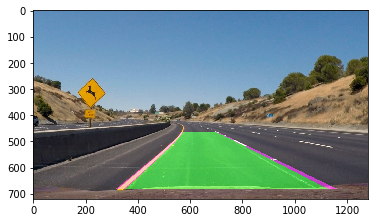

In [24]:
# draw the lane on the original image

def drawing(img,img_bin,left_fit,right_fit,M_inv):
    
    new_img = np.copy(img)
    if left_fit is None or right_fit is None:
        return img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
    heright,weight = img_bin.shape
    ploty = np.linspace(0,height - 1,num = height) # to cover the same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    pts = np.hstack((pts_left,pts_right))
    
    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))
    cv2.polylines(color_warp,np.int32([pts_left]),isClosed = False, color = (255,0,255), thickness = 15)
    cv2.polylines(color_warp,np.int32([pts_right]),isClosed = False, color = (255,0,255), thickness = 15)
    
    #warp the blank back to original image space using inverse perspective matrix (M_inv)
    newwarp = cv2.warpPerspective(color_warp,M_inv,(weight,height))
    result = cv2.addWeighted(new_img,1,newwarp,0.5,0)
    
    return result

test_output = drawing(test_image,test_img_bin,left_fit,right_fit,M_inv)
plt.imshow(test_output)

# Draw the curvature radius and distance onto the original image

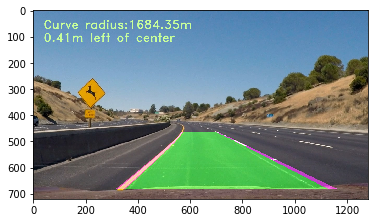

In [26]:
def draw_lane_and_data(img,curverad,center_dist):
    new_image = np.copy(img)
    h = new_image.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    test = 'Curve radius:' + '{:04.2f}'.format(curverad) + 'm'
    cv2.putText(new_image,test,(40,70),font,1.5,(200,255,155),2,cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    
    abs_center_dist = abs(center_dist)
    test = '{:04.2f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_image,test,(40,120),font,1.5,(200,255,155),2,cv2.LINE_AA)
    return new_image

test_image_output = draw_lane_and_data(test_output,(left_curverad + right_curverad)/2,center_dist)
plt.imshow(test_image_output)

# Define the line class

In [40]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

# Define image processing pipeline

In [35]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not left_line.detected or not right_line.detected:
        out_img,left_fit, right_fit, left_lane_inds, right_lane_inds,visualization_data = lane_locating(img_bin)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = window_search(left_line.best_fit, right_line.best_fit,img_bin)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        height = img.shape[0]
        left_fit_x_int = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
        right_fit_x_int = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
        x_int_diff = abs(right_fit_x_int - left_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            left_fit = None
            right_fit = None
            
    left_line.add_fit(left_fit, left_lane_inds)
    right_line.add_fit(right_fit, right_lane_inds)
    
    # draw the current best fit if it exists
    if left_line.best_fit is not None and right_line.best_fit is not None:
        img_out1 = drawing(new_img, img_bin, left_line.best_fit, right_line.best_fit, Minv)
        rad_left, rad_right, d_center = curvature(img_bin, left_line.best_fit, right_line.best_fit,left_lane_inds, right_lane_inds)
        img_out = draw_lane_and_data(img_out1, (rad_left+rad_right)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(left_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(right_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, left_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, right_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if left_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(left_fit[0]) + ' {:0.6f}'.format(left_fit[1]) + ' {:0.6f}'.format(left_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if right_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(right_fit[0]) + ' {:0.6f}'.format(right_fit[1]) + ' {:0.6f}'.format(right_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(left_line.best_fit[0]) + ' {:0.6f}'.format(left_line.best_fit[1]) + ' {:0.6f}'.format(left_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(right_line.best_fit[0]) + ' {:0.6f}'.format(right_line.best_fit[1]) + ' {:0.6f}'.format(right_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(left_line.diffs[0]) + ' {:0.6f}'.format(left_line.diffs[1]) + ' {:0.6f}'.format(left_line.diffs[2])
        if left_line.diffs[0] > 0.001 or left_line.diffs[1] > 1.0 or left_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(right_line.diffs[0]) + ' {:0.6f}'.format(right_line.diffs[1]) + ' {:0.6f}'.format(right_line.diffs[2])
        if right_line.diffs[0] > 0.001 or right_line.diffs[1] > 1.0 or right_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(left_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(right_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out

## Method for plotting a fit on a binary image - diagnostic purposes

In [41]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

# Process project

In [37]:
left_line = Line()
right_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:18<00:00,  8.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 19s


# Process challenge video

In [38]:
left_line = Line()
right_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████| 485/485 [01:00<00:00,  8.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 1s


# Process hard challenge video

In [39]:
left_line = Line()
right_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'harder_challenge_video_output.mp4'
video_input1 = VideoFileClip('harder_challenge_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


 59%|██████████████████████▉                | 707/1200 [01:45<01:02,  7.92it/s]

TypeError: expected non-empty vector for x